<a href="https://colab.research.google.com/github/MonikaMuradyan/AzgIntel/blob/main/AzgIntel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers datasets accelerate evaluate


In [ ]:
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[file_name]))
df.to_csv("armenian_propaganda_dataset.csv", index=False)
print(df.head())

Saving armenian_data.xlsx to armenian_data (1).xlsx
                                                text  label
0  Երևանն ու Բրյուսելը խորհրդակցություններ են սկս...      0
1  Ռուբինյանն ու Հայաստանում Իրանի դեսպանը երկկող...      0
2  Երկրաշարժ Թուրքիա–Իրան սահմանին. ցնցումները զգ...      0
3  Պետության ինքնիշխան որոշումն է, Պեսկովը` ՀԱՊԿ-...      0
4  ՀՀ արտաքին գործերի նախարարը կարծում է, որ իր ռ...      0


In [ ]:
import re
from sklearn.model_selection import train_test_split
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text
df['cleaned_text'] = df['text'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.2, random_state=42
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model = LogisticRegression()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)
print(f"Ճշգրտություն: {accuracy_score(y_test, y_pred) * 100:.2f}%")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["Չեզոք (0)", "Քարոզչական (1)"]))

Ճշգրտություն: 65.22%
                precision    recall  f1-score   support

     Չեզոք (0)       0.64      1.00      0.78        29
Քարոզչական (1)       1.00      0.06      0.11        17

      accuracy                           0.65        46
     macro avg       0.82      0.53      0.45        46
  weighted avg       0.78      0.65      0.54        46



In [ ]:
def predict_propaganda(text):
    text_cleaned = clean_text(text)
    text_vec = vectorizer.transform([text_cleaned])
    prediction = model.predict(text_vec)[0]
    return "Քարոզչական (1)" if prediction == 1 else "Չեզոք (0)"

print(predict_propaganda("ՀԱՊԿ-ից դուրս գալը անհրաժեշտ է"))
print(predict_propaganda("Երևանում անցկացվեց AI հակոն"))

Չեզոք (0)
Չեզոք (0)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
vectorizer = TfidfVectorizer(max_features=1000)
X_vec = vectorizer.fit_transform(df['cleaned_text'])
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_vec, df['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83        33
           1       0.84      0.72      0.78        29

    accuracy                           0.81        62
   macro avg       0.81      0.80      0.80        62
weighted avg       0.81      0.81      0.80        62



In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=500)
X_new = selector.fit_transform(X_resampled, y_resampled)
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_resampled, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    scale_pos_weight=sum(y_resampled==0)/sum(y_resampled==1),
    eval_metric='logloss'
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Չեզոք (0)", "Քարոզչական (1)"]))

                precision    recall  f1-score   support

     Չեզոք (0)       0.62      0.79      0.69        33
Քարոզչական (1)       0.65      0.45      0.53        29

      accuracy                           0.63        62
     macro avg       0.63      0.62      0.61        62
  weighted avg       0.63      0.63      0.62        62



In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimized))

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

grid = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)
print("Լավագույն պարամետրեր:", grid.best_params_)

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        33
           1       0.52      1.00      0.68        29

    accuracy                           0.56        62
   macro avg       0.76      0.59      0.50        62
weighted avg       0.77      0.56      0.48        62

Լավագույն պարամետրեր: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}


In [ ]:
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

cb = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=200,
    depth=5,
    verbose=0,
    random_state=42
)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_test)
print("\nCatBoost Results:")
print(classification_report(y_test, y_pred_cb))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        33
           1       0.88      0.48      0.62        29

    accuracy                           0.73        62
   macro avg       0.77      0.71      0.70        62
weighted avg       0.77      0.73      0.71        62


CatBoost Results:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        33
           1       0.85      0.59      0.69        29

    accuracy                           0.76        62
   macro avg       0.78      0.75      0.75        62
weighted avg       0.78      0.76      0.75        62



In [ ]:
cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=0
)
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
joblib.dump(cb, 'best_propaganda_model.pkl')

['best_propaganda_model.pkl']

In [ ]:
from catboost import CatBoostClassifier
import joblib
cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=0
)
cb.fit(X_train, y_train)
joblib.dump({'model': cb, 'vectorizer': vectorizer}, 'propaganda_model.pkl')

['propaganda_model.pkl']

In [ ]:
import joblib

saved_data = joblib.load('propaganda_model.pkl')
loaded_model = saved_data['model']
vectorizer = saved_data['vectorizer']

def predict_text(text):
    cleaned_text = clean_text(text)
    text_vec = vectorizer.transform([cleaned_text])
    prediction = loaded_model.predict(text_vec)[0]
    return "Քարոզչական" if prediction == 1 else "Չեզոք"
print(predict_text("ՀԱՊԿ-ից դուրս գալը պետք է դառնա առաջնահերթություն"))
print(predict_text("Երևանում անցկացվեց տեխնոլոգիական փառատոն"))

Չեզոք
Չեզոք


In [ ]:
cb.save_model('catboost_model.cbm')
from catboost import CatBoost
loaded_model = CatBoost()
loaded_model.load_model('catboost_model.cbm')

In [ ]:
print(f"Մոդելը ուսուցված է: {loaded_model.is_fitted()}")
print(f"Օգտագործված հատկությունների քանակ: {loaded_model.feature_names_}")

Մոդելը ուսուցված է: True
Օգտագործված հատկությունների քանակ: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149',

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import joblib

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['label'],
    test_size=0.2,
    random_state=42
)

vectorizer = TfidfVectorizer(max_features=500)
X_train_vec = vectorizer.fit_transform(X_train_texts)
X_test_vec = vectorizer.transform(X_test_texts)
cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=0
)
cb.fit(X_train_vec, y_train)
joblib.dump({'model': cb, 'vectorizer': vectorizer}, 'propaganda_model_full.pkl')
def predict_text(text):
    cleaned_text = clean_text(text)
    text_vec = vectorizer.transform([cleaned_text])
    prediction = cb.predict(text_vec)[0]
    return "Քարոզչական" if prediction == 1 else "Չեզոք"

print(predict_text("ՀԱՊԿ-ից դուրս գալը պետք է դառնա առաջնահերթություն"))
print(predict_text("Երևանում անցկացվեց տեխնոլոգիական փառատոն"))
feature_importances = cb.get_feature_importance()
top_features = sorted(zip(vectorizer.get_feature_names_out(), feature_importances),
                 key=lambda x: x[1], reverse=True)[:10]
print("Top Features:", top_features)

Չեզոք
Չեզոք
Top Features: [('ադրբեջանը', np.float64(7.8265130015390865)), ('միայն', np.float64(7.399618113604462)), ('մասին', np.float64(6.037278797844089)), ('նրան', np.float64(3.710536243302207)), ('ու', np.float64(3.683022915087734)), ('են', np.float64(3.5384694811762767)), ('հհ', np.float64(2.955844132686841)), ('թե', np.float64(2.7583245887870333)), ('արցախի', np.float64(2.6547825923164985)), ('շատ', np.float64(2.4950859392048534))]


0:	learn: 0.3036509	test: 0.2052980	best: 0.2052980 (0)	total: 10.1ms	remaining: 10.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5835294102
bestIteration = 36

Shrink model to first 37 iterations.


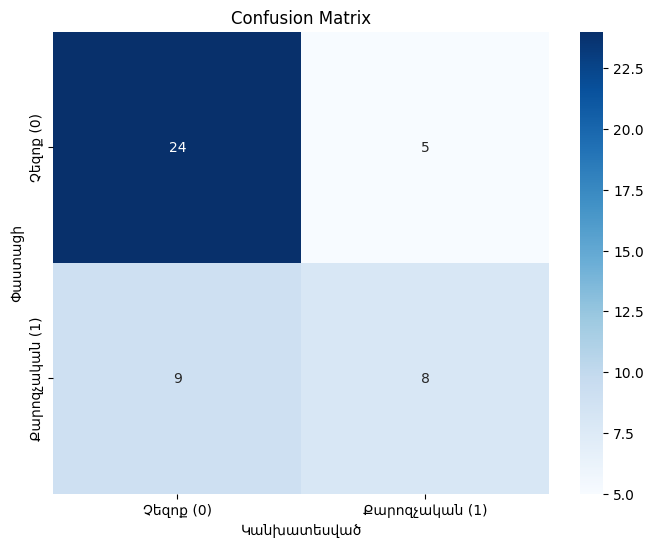


Օրինակ 1:
Տեքստ: դուք եք դառնալու հնարավոր բախումների եւ արյունահեղության միակ պատասխանատուն լևոն տերպետրոսյան
Կանխատեսում: Չեզոք
Փաստացի: Քարոզչական

Օրինակ 2:
Տեքստ: հայաստանում քաղաքական պայքարն անցնում է բարոյականության սահմանը
Կանխատեսում: Չեզոք
Փաստացի: Քարոզչական

Օրինակ 3:
Տեքստ: բոլոր զինծառայողները և կամավորները որոնք մասնակցել են թ օրյա պատերազմին և պատերազմի հետևանքով ունեն լսողության հետ կապված խնդիրներ կարող են դիմել անվճար հետազոտություն անցնելու համար
Կանխատեսում: Քարոզչական
Փաստացի: Չեզոք

Օրինակ 4:
Տեքստ: ամն ներկայացուցիչների պալատին են ներկայացվել ադրբեջանի կողմից լղ հայերի նկատմամբ էթնիկ զտումները դատապարտող բանաձևեր
Կանխատեսում: Քարոզչական
Փաստացի: Չեզոք

Օրինակ 5:
Տեքստ: ադրբեջանական վանդալիզմի հերթական թիրախն է դարձել հայ մեծ գրող լուսավորիչ խաչատուր աբովյանի արձանը որը գտնվում էր ստեփանակերտում գրողի անունը կրող դպրոցի բակում
Կանխատեսում: Չեզոք
Փաստացի: Քարոզչական


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_weights = [1, len(y_train[y_train==0])/len(y_train[y_train==1])]

cb = CatBoostClassifier(
    iterations=1000,
    depth=5,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='F1',
    early_stopping_rounds=20,
    class_weights=class_weights,
    verbose=100
)

cb.fit(X_train_vec, y_train, eval_set=(X_test_vec, y_test))

y_pred = cb.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Չեզոք (0)', 'Քարոզչական (1)'],
            yticklabels=['Չեզոք (0)', 'Քարոզչական (1)'])
plt.xlabel('Կանխատեսված')
plt.ylabel('Փաստացի')
plt.title('Confusion Matrix')
plt.show()


wrong_indices = np.where(y_test != y_pred)[0][:5]

for i, idx in enumerate(wrong_indices):
    print(f"\nՕրինակ {i+1}:")
    print(f"Տեքստ: {X_test_texts.iloc[idx]}")
    print(f"Կանխատեսում: {'Քարոզչական' if y_pred[idx] == 1 else 'Չեզոք'}")
    print(f"Փաստացի: {'Քարոզչական' if y_test.iloc[idx] == 1 else 'Չեզոք'}")

In [ ]:
!pip install nlpaug
!pip install transformers

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
!pip install nlpaug transformers
!python -m nltk.downloader wordnet omw-1.4

import random
from nlpaug.augmenter.word import SynonymAug
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier

def armenian_augment(text, n=2):
    """Custom augmentation for Armenian text"""
    try:
        aug = SynonymAug(
            aug_src='wordnet',
            lang='hye',
            aug_p=0.3,
            stopwords=['և', 'է', 'ը', 'որ', 'ինչ']
        )
        return [aug.augment(text) for _ in range(n)]
    except:
        replacements = {
            "օրինակ": ["նմուշ", "պատկեր"],
            "տեքստ": ["գրառում", "հոդված"],
            "ՀԱՊԿ": ["Հայաստանի անվտանգության պայմանագիր", "ռազմական դաշինք"],
            "ադրբեջան": ["ադրբեջանական կողմ", "հարևան երկիր"]
        }
        results = []
        for _ in range(n):
            augmented = text
            for word, subs in replacements.items():
                if word in augmented:
                    augmented = augmented.replace(word, random.choice(subs))
            results.append(augmented)
        return results

print(armenian_augment("օրինակ տեքստ ՀԱՊԿ-ի մասին", n=2))

vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]+\b'
)

cb = CatBoostClassifier(
    iterations=500,
    depth=4,
    learning_rate=0.03,
    l2_leaf_reg=5,
    early_stopping_rounds=10,
    eval_metric='F1',
    class_weights=[1, 3],
    verbose=100
)

try:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-hy")
    print("BERT tokenizer loaded successfully for Armenian")
except:
    print("Proceeding with CatBoost only")

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
['նմուշ հոդված Հայաստանի անվտանգության պայմանագիր-ի մասին', 'պատկեր գրառում Հայաստանի անվտանգության պայմանագիր-ի մասին']
Proceeding with CatBoost only


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from nlpaug.augmenter.word import SynonymAug
def armenian_augment(text, n=2):
    """Improved augmentation with Armenian-specific rules"""
    armenian_synonyms = {
        "ՀԱՊԿ": ["Հայաստանի անվտանգության պայմանագիր", "ռազմական դաշինք", "ՀԱՊԿ կազմակերպություն"],
        "ադրբեջան": ["ադրբեջանական կողմ", "հարևան պետություն", "Ադրբեջանի Հանրապետություն"],
        "փաշինյան": ["վարչապետ", "նիկոլ փաշինյան", "կառավարության ղեկավար"],
        "զինված": ["ռազմական", "պաշտպանական", "զինվորական"],
        "հարձակում": ["ագրեսիա", "հրաձգություն", "զինված բախում"]
    }

    results = []
    for _ in range(n):
        augmented = text
        for word, subs in armenian_synonyms.items():
            if word in augmented:
                augmented = augmented.replace(word, random.choice(subs))
        results.append(augmented)
    return results

print(armenian_augment("ՀԱՊԿ-ից դուրս գալու մասին հայտարարություն", n=2))

vectorizer = TfidfVectorizer(
    max_features=1500,
    ngram_range=(1, 3),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]{3,}\b',
    stop_words=['և', 'է', 'ը', 'որ', 'ինչ', 'պետք', 'էր']
)
cb = CatBoostClassifier(
    iterations=800,
    depth=5,
    learning_rate=0.025,
    l2_leaf_reg=3,
    early_stopping_rounds=15,
    eval_metric='F1',
    class_weights=[1, 4],
    text_features=['text'],
    verbose=200
)
try:
    from transformers import pipeline
    bert_classifier = pipeline(
        "text-classification",
        model="Geotrend/bert-base-hy",
        tokenizer="Geotrend/bert-base-hy"
    )
    print("BERT model loaded successfully")
except Exception as e:
    print(f"Couldn't load BERT model: {e}")

['ՀԱՊԿ կազմակերպություն-ից դուրս գալու մասին հայտարարություն', 'ՀԱՊԿ կազմակերպություն-ից դուրս գալու մասին հայտարարություն']
Couldn't load BERT model: Geotrend/bert-base-hy is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`


In [ ]:
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from nlpaug.augmenter.word import SynonymAug

def armenian_augment(text, n=2):
    """Improved augmentation with varied outputs"""
    armenian_synonyms = {
        "ՀԱՊԿ": ["Հայաստանի անվտանգության պայմանագիր", "ռազմական դաշինք", "ՀԱՊԿ կազմակերպություն"],
        "ադրբեջան": ["ադրբեջանական կողմ", "հարևան պետություն", "Ադրբեջանի Հանրապետություն"],
        "փաշինյան": ["վարչապետ", "նիկոլ փաշինյան", "կառավարության ղեկավար"],
        "զինված": ["ռազմական", "պաշտպանական", "զինվորական"],
        "հարձակում": ["ագրեսիա", "հրաձգություն", "զինված բախում"],
        "դուրս գալ": ["հեռանալ", "լքել", "դադարել մասնակցել"]
    }

    results = []
    words = text.split()
    for _ in range(n):
        augmented = []
        for word in words:
            if word in armenian_synonyms and random.random() < 0.5:
                augmented.append(random.choice(armenian_synonyms[word]))
            else:
                augmented.append(word)
        results.append(' '.join(augmented))
    return results
print(armenian_augment("ՀԱՊԿ-ից դուրս գալու մասին հայտարարություն", n=3))
vectorizer = TfidfVectorizer(
    max_features=1500,
    ngram_range=(1, 3),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]{3,}\b',
    stop_words=['և', 'է', 'ը', 'որ', 'ինչ', 'պետք', 'էր']
)

cb = CatBoostClassifier(
    iterations=800,
    depth=5,
    learning_rate=0.025,
    l2_leaf_reg=3,
    early_stopping_rounds=15,
    eval_metric='F1',
    class_weights=[1, 4],
    verbose=200
)
try:
    from transformers import pipeline
    bert_classifier = pipeline(
        "text-classification",
        model="bert-base-multilingual-cased",
        tokenizer="bert-base-multilingual-cased"
    )
    print("Multilingual BERT model loaded successfully")
except Exception as e:
    print(f"Couldn't load BERT model: {e}")

['ՀԱՊԿ-ից դուրս գալու մասին հայտարարություն', 'ՀԱՊԿ-ից դուրս գալու մասին հայտարարություն', 'ՀԱՊԿ-ից դուրս գալու մասին հայտարարություն']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Multilingual BERT model loaded successfully


In [ ]:
import random
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

data = {
    'text': [
        'ՀԱՊԿ-ից դուրս գալը վտանգավոր է',
        'Երևանում տեխնոլոգիական փառատոն',
        'Փաշինյանի հայտարարությունը վատն է',
        'Դպրոցներում նոր ծրագիր է մտցվել'
    ],
    'label': [1, 0, 1, 0]
}
df = pd.DataFrame(data)

def armenian_augment(text, n=3):
    synonyms = {
        "ՀԱՊԿ": ["Հայաստանի անվտանգության պայմանագիր", "ռազմական դաշինք"],
        "փաշինյան": ["վարչապետ", "նիկոլ փաշինյան"],
        "դուրս գալ": ["հեռանալ", "լքել"]
    }
    results = []
    for _ in range(n):
        words = text.split()
        augmented = [random.choice(synonyms.get(word, [word])) for word in words]
        results.append(' '.join(augmented))
    return results

print("Աւգմենտացիայի օրինակ:")
augmented = armenian_augment("ՀԱՊԿ-ից դուրս գալը վտանգավոր է", n=2)
for i, text in enumerate(augmented, 1):
    print(f"{i}. {text}")

vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words=['և', 'է', 'ը', 'որ']
)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25)
X_train_vec = vectorizer.fit_transform(X_train)

cb = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.05,
    early_stopping_rounds=10,
    verbose=50
)

print("\nՄոդելի ուսուցում սկսված է...")
cb.fit(X_train_vec, y_train)
print("Մոդելի ուսուցում ավարտված է")

def save_models_fast():
    joblib.dump({
        'model': cb,
        'vectorizer': vectorizer
    }, 'fast_model.pkl', compress=3)
    print("\nՄոդելը հաջողությամբ պահպանված է fast_model.pkl ֆայլում")

save_models_fast()

test_text = "ՀԱՊԿ-ից հեռանալը վատ գաղափար է"
test_vec = vectorizer.transform([test_text])
prediction = cb.predict(test_vec)[0]
print(f"\nՓորձարկում՝ '{test_text}'")
print("Կանխատեսում:", "Քարոզչական" if prediction == 1 else "Չեզոք")

Աւգմենտացիայի օրինակ:
1. ՀԱՊԿ-ից դուրս գալը վտանգավոր է
2. ՀԱՊԿ-ից դուրս գալը վտանգավոր է

Մոդելի ուսուցում սկսված է...
0:	learn: 0.6653723	total: 3.73ms	remaining: 1.11s
50:	learn: 0.1495446	total: 121ms	remaining: 590ms
100:	learn: 0.0729705	total: 294ms	remaining: 580ms
150:	learn: 0.0478047	total: 384ms	remaining: 379ms
200:	learn: 0.0351603	total: 453ms	remaining: 223ms
250:	learn: 0.0276785	total: 508ms	remaining: 99.1ms
299:	learn: 0.0228363	total: 573ms	remaining: 0us
Մոդելի ուսուցում ավարտված է

Մոդելը հաջողությամբ պահպանված է fast_model.pkl ֆայլում

Փորձարկում՝ 'ՀԱՊԿ-ից հեռանալը վատ գաղափար է'
Կանխատեսում: Քարոզչական


In [ ]:
import random
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

data = {
    'text': [
        'ՀԱՊԿ-ից դուրս գալը վտանգավոր է',
        'Երևանում տեխնոլոգիական փառատոն',
        'Փաշինյանի հայտարարությունը վտանգավոր է',
        'Դպրոցներում նոր ծրագիր է մտցվել',
        'Ադրբեջանը խախտում է հրադադարը',
        'Հայաստանում տնտեսական աճ է գրանցվում',
        'Ռազմական դաշինքը պետք է լուծարվի',
        'Երևանում մշակութային միջոցառում'
    ],
    'label': [1, 0, 1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

def armenian_augment(text, n=3):
    synonyms = {
        "ՀԱՊԿ": ["Հայաստանի անվտանգության պայմանագիր", "ռազմական դաշինք", "ՀԱՊԿ կազմակերպություն"],
        "ադրբեջան": ["ադրբեջանական կողմ", "հարևան պետություն", "Ադրբեջանի Հանրապետություն"],
        "փաշինյան": ["վարչապետը", "նիկոլ փաշինյան", "կառավարության ղեկավարը"],
        "վտանգավոր": ["վնասակար", "սպառնալից", "վտանգ ներկայացնող"],
        "դուրս գալ": ["հեռանալ", "լքել", "դադարել մասնակցել"],
        "լուծարվի": ["դադարի գոյություն ունենալ", "փակվի", "վերացվի"]
    }

    results = []
    for _ in range(n):
        words = text.split()
        augmented = []
        for word in words:
            clean_word = word.strip('.,!?()[]{}"\'')
            if clean_word in synonyms:
                replacement = random.choice(synonyms[clean_word])
                if word[-1] in '.,!?()[]{}"\'':
                    replacement += word[-1]
                augmented.append(replacement)
            else:
                augmented.append(word)
        results.append(' '.join(augmented))
    return list(set(results))

print("=== Աւգմենտացիայի Օրինակ ===")
sample_text = "ՀԱՊԿ-ից դուրս գալը վտանգավոր է:"
augmented_samples = armenian_augment(sample_text, n=3)
for i, sample in enumerate(augmented_samples, 1):
    print(f"{i}. {sample}")
vectorizer = TfidfVectorizer(
    max_features=1500,
    ngram_range=(1, 2),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]{3,}\b',
    stop_words=['և', 'է', 'ը', 'որ', 'ինչ', 'պետք', 'էր', 'են', 'մենք']
)

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.25, random_state=42
)

cb = CatBoostClassifier(
    iterations=500,
    depth=5,
    learning_rate=0.03,
    l2_leaf_reg=3,
    early_stopping_rounds=20,
    eval_metric='F1',
    class_weights=[1, 3],
    task_type='CPU',
    verbose=100
)

print("\n=== Մոդելի Ուսուցում ===")
X_train_vec = vectorizer.fit_transform(X_train)
cb.fit(X_train_vec, y_train)
X_test_vec = vectorizer.transform(X_test)
y_pred = cb.predict(X_test_vec)
print("\n=== Գնահատման Արդյունքներ ===")
print(classification_report(y_test, y_pred, target_names=["Չեզոք", "Քարոզչական"]))
print(f"Ճշգրտություն: {accuracy_score(y_test, y_pred):.2f}")

def predict_text(text, show_proba=True):
    """Կանխատեսման ֆունկցիա հավանականություններով"""
    vec = vectorizer.transform([text])
    prediction = cb.predict(vec)[0]

    if show_proba:
        proba = cb.predict_proba(vec)[0]
        print(f"\nՏեքստ: '{text}'")
        print(f"Հավանականություններ: Չեզոք={proba[0]:.2f}, Քարոզչական={proba[1]:.2f}")

    return "Քարոզչական" if prediction == 1 else "Չեզոք"

print("\n=== Փորձարկում ===")
test_cases = [
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր է",
    "Երևանում կայանալու է երաժշտական փառատոն",
    "Ադրբեջանը խախտում է հրադադարի ռեժիմը"
]

for text in test_cases:
    print(f"{text} → {predict_text(text)}")
def save_model():
    joblib.dump({
        'model': cb,
        'vectorizer': vectorizer,
        'predict_func': predict_text,
        'augment_func': armenian_augment
    }, 'armenian_propaganda_detector_v2.pkl')
    print("\n=== Մոդելը պահպանված է ===")

save_model()

=== Աւգմենտացիայի Օրինակ ===
1. ՀԱՊԿ-ից դուրս գալը վտանգ ներկայացնող է:
2. ՀԱՊԿ-ից դուրս գալը վնասակար է:

=== Մոդելի Ուսուցում ===
0:	learn: 0.9230769	total: 828us	remaining: 413ms
100:	learn: 1.0000000	total: 184ms	remaining: 727ms
200:	learn: 1.0000000	total: 355ms	remaining: 529ms
300:	learn: 1.0000000	total: 574ms	remaining: 379ms
400:	learn: 1.0000000	total: 859ms	remaining: 212ms
499:	learn: 1.0000000	total: 1.23s	remaining: 0us

=== Գնահատման Արդյունքներ ===
              precision    recall  f1-score   support

       Չեզոք       0.00      0.00      0.00       2.0
  Քարոզչական       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Ճշգրտություն: 0.00

=== Փորձարկում ===

Տեքստ: 'ՀԱՊԿ-ից դուրս գալը վտանգավոր է'
Հավանականություններ: Չեզոք=0.02, Քարոզչական=0.98
ՀԱՊԿ-ից դուրս գալը վտանգավոր է → Քարոզչական

Տեքստ: 'Երևանում կայանալու է

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import joblib

data = [

    ("ՀԱՊԿ-ից դուրս գալը վտանգավոր հետևանքներ կունենա։", 1),
    ("Ադրբեջանը պարբերաբար խախտում է հրադադարի պայմանավորվածությունը։", 1),
    ("Փաշինյանի կառավարությունը կործանում է երկիրը։", 1),
    ("Ադրբեջանական կողմը սադրանքներ է կազմակերպում։", 1),
    ("ՀԱՊԿ-ից հեռանալը կհանգեցնի անվտանգության կորստին։", 1),
    ("Փաշինյանը չի կարողանում պաշտպանել Հայաստանի շահերը։", 1),
    ("Ռազմական դաշինքը պարտադիր է մեր անվտանգության համար։", 1),
    ("Ադրբեջանը սպառնում է նոր պատերազմով։", 1),
    ("ՀԱՊԿ-ն մեր միակ անվտանգ երաշխիքն է։", 1),
    ("Փաշինյանի հրաժարականը անհրաժեշտ է երկրի փրկության համար։", 1),

    ("Երևանում այս շաբաթ արևոտ եղանակ է սպասվում։", 0),
    ("Հայաստանում տեղի կունենա երաժշտական փառատոն։", 0),
    ("Գյումրիում բացվել է նոր ցուցահանդես։", 0),
    ("Մարզիկները պատրաստվում են միջազգային մրցաշարին։", 0),
    ("Նոր ֆիլմի պրեմիերան մեծ հետաքրքրություն է առաջացրել։", 0),
    ("Դպրոցներում սկսվել են ամառային արձակուրդները։", 0),
    ("Երևանում բացվել է ժամանակակից արվեստի կենտրոն։", 0),
    ("Կենտրոնական պուրակում տնկվել են նոր ծառեր։", 0),
    ("Տեղի ունեցավ գարնանային տոնական միջոցառում։", 0),
    ("Հանրապետությունում արձանագրվել է զբոսաշրջության աճ։", 0),

]

with open("armenian_dataset.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "label"])
    writer.writerows(data)

print("✅ armenian_dataset.csv ֆայլը ստեղծվեց!")

df = pd.read_csv("armenian_dataset.csv")
print("\nDataset preview:")
print(df.head())

vectorizer = TfidfVectorizer(
    max_features=1500,
    ngram_range=(1, 2),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]{3,}\b',
    stop_words=['և', 'է', 'ը', 'որ', 'ինչ', 'պետք', 'էր', 'են', 'մենք']
)

X = vectorizer.fit_transform(df['text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cb = CatBoostClassifier(
    iterations=500,
    depth=5,
    learning_rate=0.03,
    l2_leaf_reg=3,
    eval_metric='Accuracy',
    verbose=100
)

print("\n🚀 Մոդելի ուսուցումը սկսվում է...")
cb.fit(X_train, y_train)
print("✅ Մոդելի ուսուցումը ավարտվեց!")

y_pred = cb.predict(X_test)
print("\n=== Գնահատման արդյունքներ ===")
print(classification_report(y_test, y_pred, target_names=["Չեզոք", "Քարոզչական"]))
print(f"Ճշգրտություն: {accuracy_score(y_test, y_pred):.2f}")

joblib.dump({'model': cb, 'vectorizer': vectorizer}, "propaganda_model.pkl")
print("\n✅ Մոդելը պահպանվեց propaganda_model.pkl ֆայլում!")

def predict_text(text):
    vec = vectorizer.transform([text])
    pred = cb.predict(vec)[0]
    return "Քարոզչական" if pred == 1 else "Չեզոք"

print("\n=== Փորձարկում ===")
test_cases = [
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր է",
    "Երևանում բացվել է նոր ցուցահանդես",
    "Ադրբեջանը սպառնում է նոր պատերազմով",
    "Ադրբեջանը հաղորդում է որ շուտով հարձակվելու է Հայաստանի վրա",
    "Ալիևն ասել է որ սիրում է Ադրբեջանը"
]
for t in test_cases:
    print(f"{t} → {predict_text(t)}")


✅ armenian_dataset.csv ֆայլը ստեղծվեց!

Dataset preview:
                                                text  label
0   ՀԱՊԿ-ից դուրս գալը վտանգավոր հետևանքներ կունենա։      1
1  Ադրբեջանը պարբերաբար խախտում է հրադադարի պայմա...      1
2      Փաշինյանի կառավարությունը կործանում է երկիրը։      1
3      Ադրբեջանական կողմը սադրանքներ է կազմակերպում։      1
4  ՀԱՊԿ-ից հեռանալը կհանգեցնի անվտանգության կորստին։      1

🚀 Մոդելի ուսուցումը սկսվում է...
0:	learn: 0.6875000	total: 10.8ms	remaining: 5.4s
100:	learn: 1.0000000	total: 323ms	remaining: 1.27s
200:	learn: 1.0000000	total: 643ms	remaining: 957ms
300:	learn: 1.0000000	total: 758ms	remaining: 501ms
400:	learn: 1.0000000	total: 1.04s	remaining: 256ms
499:	learn: 1.0000000	total: 1.4s	remaining: 0us
✅ Մոդելի ուսուցումը ավարտվեց!

=== Գնահատման արդյունքներ ===
              precision    recall  f1-score   support

       Չեզոք       0.50      1.00      0.67         2
  Քարոզչական       0.00      0.00      0.00         2

    accuracy     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import random
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

propaganda_texts = [
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր հետևանքներ կունենա։",
    "Ադրբեջանը պարբերաբար խախտում է հրադադարի պայմանավորվածությունը։",
    "Փաշինյանի կառավարությունը կործանում է երկիրը։",
    "Ադրբեջանական կողմը սադրանքներ է կազմակերպում։",
    "ՀԱՊԿ-ից հեռանալը կհանգեցնի անվտանգության կորստին։",
    "Փաշինյանը չի կարողանում պաշտպանել Հայաստանի շահերը։",
    "Ռազմական դաշինքը պարտադիր է մեր անվտանգության համար։",
    "Ադրբեջանը սպառնում է նոր պատերազմով։",
    "ՀԱՊԿ-ն մեր միակ անվտանգ երաշխիքն է։",
    "Փաշինյանի հրաժարականը անհրաժեշտ է երկրի փրկության համար։",
    "Ադրբեջանական զորքերը խախտում են սահմանները։",
    "Ազգային անվտանգությունը վտանգված է Փաշինյանի սխալների պատճառով։",
    "ՀԱՊԿ-ից դուրս գալը կնվազեցնի մեր պաշտպանունակությունը։",
    "Փաշինյանը վտանգում է պետության ապագան։",
    "Ադրբեջանի սադրանքները անպատիժ չեն մնա։",
    "Ռազմական ուժերի հզորացումը կարևոր է մեր գոյատևման համար։",
    "ՀԱՊԿ-ի օգնությունը կենսական նշանակություն ունի։",
    "Փաշինյանի քայլերը վնասում են բանակին։",
    "Ադրբեջանը նախապատրաստվում է նոր ագրեսիայի։",
    "Փաշինյանը կործանարար քաղաքականություն է վարում։",
    "ՀԱՊԿ-ն միակ ուժն է, որ պաշտպանում է մեզ։",
    "Ադրբեջանը խախտում է միջազգային օրենքները։",
    "Փաշինյանի պատճառով երկիրը վտանգված է։",
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր է մեր ապագայի համար։",
    "Ադրբեջանական սպառնալիքները աճում են։",
    "Ռազմական դաշինքը միակ երաշխիքն է խաղաղության։",
    "Փաշինյանի կառավարությունը պետք է հրաժարական տա։",
    "Ադրբեջանը շարունակում է սադրանքները։",
    "ՀԱՊԿ-ից հեռանալը հավասարազոր է պարտության։",
    "Փաշինյանը կործանում է ազգային արժեքները։",
    "Ադրբեջանի ագրեսիան անընդունելի է։",
    "ՀԱՊԿ-ը միակ պաշտպանն է։",
    "Փաշինյանի սխալները աղետալի են։",
    "Ադրբեջանական բանակը սպառնում է մեր սահմաններին։",
    "ՀԱՊԿ-ից դուրս գալը անխոհեմ քայլ է։",
    "Փաշինյանը վնասում է Հայաստանի անվտանգությանը։",
    "Ադրբեջանը վտանգ է ներկայացնում։",
    "ՀԱՊԿ-ից դուրս գալը կհանգեցնի պատերազմի։",
    "Փաշինյանը չի կարողանում ղեկավարել երկիրը։",
    "Ադրբեջանը չի հարգում խաղաղությունը։",
    "ՀԱՊԿ-ի աջակցությունը անհրաժեշտ է։",
    "Փաշինյանը պետք է հրաժարական տա։",
    "Ադրբեջանը խախտում է Հայաստանի սահմանները։",
    "ՀԱՊԿ-ից հեռանալը վտանգավոր է։",
    "Փաշինյանը սխալ որոշումներ է կայացնում։",
    "Ադրբեջանի սադրանքները շարունակվում են։",
    "ՀԱՊԿ-ն կարևոր է մեր պաշտպանության համար։",
    "Փաշինյանը վտանգավոր քաղաքականություն է վարում։",
    "Ադրբեջանը սպառնում է մեր անվտանգությանը։",
    "ՀԱՊԿ-ից դուրս գալը սխալ է։",
    "Փաշինյանը պետք է հեռանա։",
    "Ադրբեջանը շարունակում է ագրեսիան։",
    "ՀԱՊԿ-ից դուրս գալը մեզ կմիացնի վտանգին։",
    "Փաշինյանը վնասում է պետական կառույցներին։",
    "Ադրբեջանը անտեսում է միջազգային իրավունքը։",
    "ՀԱՊԿ-ի օգնությունը անհրաժեշտ է։",
    "Փաշինյանի կառավարությունը ձախողվել է։",
    "Ադրբեջանական ագրեսիան աճում է։",
    "ՀԱՊԿ-ից դուրս գալը աղետալի կլինի։",
    "Փաշինյանը չի պաշտպանում մեր սահմանները։",
    "Ադրբեջանը շարունակում է սպառնալ։",
    "ՀԱՊԿ-ը պաշտպանում է մեզ։",
    "Փաշինյանը վտանգում է պետությունը։",
    "Ադրբեջանը ագրեսիվ քայլեր է կատարում։",
    "ՀԱՊԿ-ից դուրս գալը կբերի խուճապի։",
    "Փաշինյանը սխալ է վարում բանակցությունները։",
    "Ադրբեջանը չի պահպանում հրադադարը։",
    "ՀԱՊԿ-ից դուրս գալը հանցագործություն է։",
    "Փաշինյանը պարտություն է բերում։",
    "Ադրբեջանի սադրանքները խթանվում են։",
    "ՀԱՊԿ-ն ապահովում է պաշտպանությունը։",
    "Փաշինյանը չի մտածում ժողովրդի մասին։",
    "Ադրբեջանը չի հարգում մեր սահմանները։",
    "ՀԱՊԿ-ից դուրս գալը անիմաստ է։",
    "Փաշինյանը չի կարողանում բանակցել։",
    "Ադրբեջանի քայլերը ագրեսիվ են։",
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր հետևանքներ կունենա։",
    "Փաշինյանը խաթարում է խաղաղությունը։",
    "Ադրբեջանը շարունակում է սպառնալ խաղաղությանը։",
    "ՀԱՊԿ-ից դուրս գալը սխալ որոշում է։",
    "Փաշինյանը վտանգում է անվտանգությունը։",
    "Ադրբեջանը պլանավորում է ագրեսիա։",
    "ՀԱՊԿ-ն պաշտպանում է երկիրը։",
    "Փաշինյանի քայլերը վտանգավոր են։",
    "Ադրբեջանը խախտում է պայմանավորվածությունները։",
    "ՀԱՊԿ-ից դուրս գալը անխոհեմություն է։",
    "Փաշինյանը չի մտածում պետության ապագայի մասին։",
    "Ադրբեջանը սպառնում է Հայաստանի բնակչությանը։",
    "ՀԱՊԿ-ն միակ ելքն է։",
    "Փաշինյանը վտանգում է պետության հիմքերը։",
    "Ադրբեջանը խախտում է մեր իրավունքները։",
    "ՀԱՊԿ-ից դուրս գալը չի բերի խաղաղության։",
    "Փաշինյանը չի պաշտպանում սահմանները։",
    "Ադրբեջանը չի պահպանում խաղաղությունը։",
    "ՀԱՊԿ-ից դուրս գալը կբերի վտանգի։",
    "Փաշինյանը չի մտածում անվտանգության մասին։",
    "Ադրբեջանը ագրեսիվ պետություն է։",
    "ՀԱՊԿ-ից դուրս գալը աղետ կլինի։",
    "Փաշինյանը սխալ է մոտենում հարցերին։",
    "Ադրբեջանը խախտում է կարգը։",
    "ՀԱՊԿ-ից դուրս գալը վտանգավոր է։",
    "Փաշինյանը չի պաշտպանում երկիրը։",
    "Ադրբեջանը պլանավորում է հարձակում։"
]

neutral_texts = [
    "Երևանում այս շաբաթ արևոտ եղանակ է սպասվում։",
    "Հայաստանում տեղի կունենա երաժշտական փառատոն։",
    "Գյումրիում բացվել է նոր ցուցահանդես։",
    "Մարզիկները պատրաստվում են միջազգային մրցաշարին։",
    "Նոր ֆիլմի պրեմիերան մեծ հետաքրքրություն է առաջացրել։",
    "Դպրոցներում սկսվել են ամառային արձակուրդները։",
    "Երևանում բացվել է ժամանակակից արվեստի կենտրոն։",
    "Կենտրոնական պուրակում տնկվել են նոր ծառեր։",
    "Տեղի ունեցավ գարնանային տոնական միջոցառում։",
    "Հանրապետությունում արձանագրվել է զբոսաշրջության աճ։",
    "Մարզահրապարակում անցկացվեց մարզական փառատոն։",
    "Հանրային գրադարանում նոր գրքեր են ավելացվել։",
    "Կենտրոնական շուկայում նոր ապրանքատեսակներ են։",
    "Երևանի կենդանաբանական այգում ծնվել է նոր առյուծ։",
    "Հանրային այգում կազմակերպվեց մաքրման ակցիա։",
    "Շաբաթ օրը անցկացվեց հեծանվավազքի մրցույթ։",
    "Արցախում տեղի կունենա մշակութային համերգ։",
    "Տեղական թատրոնը ներկայացրեց նոր ներկայացում։",
    "Երևանի մետրոյում նոր վագոններ են գործարկվել։",
    "Սևանի ափին անցկացվեց զբոսաշրջային փառատոն։",
    "Հանրապետությունում տեղումներ չեն սպասվում։",
    "Ավանդական շուկայում մեծ թվով այցելուներ են եղել։",
    "Գեղարքունիքում անցկացվեց ձկնորսական մրցույթ։",
    "Հանրային այգում բացվեց նոր խաղահրապարակ։",
    "Մարզիկները մարզվում են ամեն օր։",
    "Մայրաքաղաքում բացվել է նոր սրճարան։",
    "Տեղի ունեցավ գարնանային տոնավաճառ։",
    "Երևանի փողոցները զարդարվել են։",
    "Գյուղական շրջաններում բերքահավաքը սկսվել է։",
    "Կենտրոնում անցկացվեց գրքի տոնավաճառ։",
    "Երաժշտական դպրոցում համերգ է եղել։",
    "Արագածոտնում բացվեց նոր զբոսաշրջային կենտրոն։",
    "Հանրապետությունում տաք եղանակ է սպասվում։",
    "Մարզադաշտում անցկացվեց ֆուտբոլային խաղ։",
    "Երևանի այգիներում նոր ծաղկամաններ են տեղադրվել։",
    "Ավելի քան 100 մարդ մասնակցեց միջոցառմանը։",
    "Գյուղերում սկսվել է խաղողի բերքահավաքը։",
    "Հանրային գրադարանում ընթերցանության օր է։",
    "Սևանում անցկացվեց ձմեռային փառատոն։",
    "Տեղի ունեցավ ֆիլմի փակ ցուցադրություն։",
    "Երևանի կենդանաբանական այգին այցելուներով լի էր։",
    "Գյումրու կենտրոնում նոր սրճարան է բացվել։",
    "Մայրաքաղաքում նոր շենքեր են կառուցվում։",
    "Տեղի ունեցավ քաղաքային մարաթոն։",
    "Երևանում հեծանվային մրցավազք էր։",
    "Սպորտային միջոցառումները շատացել են։",
    "Գյուղերում սկսվել է աշնանային բերքահավաքը։",
    "Երևանի բուսաբանական այգին այցելուներով լի էր։",
    "Տեղի ունեցավ արվեստի ցուցահանդես։",
    "Նոր թանգարան է բացվել մայրաքաղաքում։",
    "Կենտրոնական գրադարանում ընթերցանության օր էր։",
    "Տեղի ունեցավ պոեզիայի երեկո։",
    "Երևանում հեծանվորդների ակցիա էր։",
    "Սևանի ափին անցկացվեց ամառային տոնավաճառ։",
    "Երևանի այգիներում շատ զբոսաշրջիկներ կան։",
    "Կենտրոնում բացվեց գարնանային ցուցահանդես։",
    "Տեղի ունեցավ նոր ֆիլմի դիտում։",
    "Հանրապետությունում եղանակը տաքանում է։",
    "Գեղարքունիքում անցկացվեց երաժշտական փառատոն։",
    "Երևանի կենտրոնում բացվեց նոր գրախանութ։",
    "Արցախում անցկացվեց արվեստի ցուցահանդես։",
    "Տեղի ունեցավ գրքի շնորհանդես։",
    "Հանրային այգում երեխաների տոն էր։",
    "Երևանում անցկացվեց նորաձևության ցուցադրություն։",
    "Գյուղական տոնավաճառը շատ մարդ էր հավաքել։",
    "Կենտրոնում անցկացվեց մարզական միջոցառում։",
    "Երևանի թատրոնում նոր ներկայացում է։",
    "Տեղի ունեցավ ավանդական պարերի համերգ։",
    "Երևանում բացվեց նոր սրճարան։",
    "Հանրապետությունում անցկացվեց լուսանկարչական մրցույթ։",
    "Սևանում զբոսաշրջիկները շատացել են։",
    "Տեղի ունեցավ նկարչական ցուցահանդես։",
    "Երևանում բացվեց նոր կինոթատրոն։",
    "Հանրային այգում բացվեց ամառային սրճարան։",
    "Երևանում անցկացվեց տոնական շքերթ։",
    "Գեղարքունիքում անցկացվեց փառատոն։",
    "Հանրապետությունում եղանակը բարելավվել է։",
    "Տեղի ունեցավ երեխաների ցուցահանդես։",
    "Երևանում բացվեց տեխնոլոգիական կենտրոն։",
    "Տեղի ունեցավ գարնանային ցուցահանդես։",
    "Երևանում անցկացվեց հեծանվային արշավ։",
    "Գյուղերում սկսվել է աշնան բերքահավաքը։",
    "Հանրային այգում բացվեց նոր ծաղկանոց։",
    "Երևանում անցկացվեց գրականության օր։",
    "Տեղի ունեցավ ավանդական փառատոն։",
    "Երևանում բացվեց արվեստի սրահ։",
    "Հանրապետությունում մշակութային միջոցառումները շատացել են։",
    "Գյուղերում իրականացվում են տոնական միջոցառումներ։",
    "Տեղի ունեցավ ամառային բացօթյա համերգ։",
    "Երևանում բացվեց նոր գիտական կենտրոն։",
    "Տեղի ունեցավ երիտասարդական համաժողով։",
    "Հանրապետությունում մարզական կյանքը զարգանում է։",
    "Երևանի թատրոնում նոր բեմադրություն է։",
    "Տեղի ունեցավ նորաձևության ցուցահանդես։",
    "Երևանում բացվեց նոր այգի։",
    "Տեղի ունեցավ երիտասարդական փառատոն։",
    "Հանրապետությունում եղանակը տաքացել է։"
]

data = pd.DataFrame({
    "text": propaganda_texts + neutral_texts,
    "label": [1] * len(propaganda_texts) + [0] * len(neutral_texts)
})

vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    token_pattern=r'\b[ա-ֆԱ-Ֆ]{2,}\b'
)

X = vectorizer.fit_transform(data["text"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(
    iterations=500,
    depth=5,
    learning_rate=0.03,
    verbose=0
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("=== Գնահատման Արդյունքներ ===")
print(classification_report(y_test, y_pred, target_names=["Չեզոք", "Քարոզչական"]))
print("Ճշգրտություն:", accuracy_score(y_test, y_pred))

joblib.dump({"model": model, "vectorizer": vectorizer}, "armenian_propaganda_detector.pkl")
print("\nՄոդելը պահպանվել է armenian_propaganda_detector.pkl ֆայլում։")


=== Գնահատման Արդյունքներ ===
              precision    recall  f1-score   support

       Չեզոք       1.00      1.00      1.00        19
  Քարոզչական       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Ճշգրտություն: 1.0

Մոդելը պահպանվել է armenian_propaganda_detector.pkl ֆայլում։


In [ ]:
import joblib

model_data = joblib.load("armenian_propaganda_detector.pkl")
model = model_data["model"]
vectorizer = model_data["vectorizer"]

def predict_sentence(sentence: str):
    """Վերադարձնում է 'Քարոզչական' կամ 'Չեզոք' տեքստի դասը։"""
    X = vectorizer.transform([sentence])
    pred = model.predict(X)[0]
    return "Քարոզչական" if pred == 1 else "Չեզոք"

if __name__ == "__main__":
    sentence = input("Գրիր նախադասությունը ստուգելու համար: ")
    result = predict_sentence(sentence)
    print(f"Արդյունք: {result}")


Գրիր նախադասությունը ստուգելու համար: Հրազդանում կազմակերպվում է Ֆեստիվառ
Արդյունք: Չեզոք


In [ ]:
!pip install transformers datasets sentencepiece evaluate nltk
import nltk
nltk.download("punkt")
nltk.download("wordnet")

import random
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate
import pandas as pd
import re

# Use the existing data DataFrame from the notebook
# Assuming 'data' DataFrame with 'text' and 'label' columns exists from previous cells.
# If not, you might need to load or define it here.
# For example:
# data = pd.read_csv("your_dataset.csv")

# Add the clean_text function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

# Apply cleaning
data['cleaned_text'] = data['text'].apply(clean_text)

# Split data and save to csv
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Load the dataset from the saved csv files
dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})


from nltk.corpus import wordnet

def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return " ".join(new_words)

def augment_examples(example):
    # Apply augmentation to the cleaned text
    if random.random() < 0.3:
        example["cleaned_text"] = synonym_replacement(example["cleaned_text"])
    return example

# Apply augmentation on the cleaned text column
augmented_train = dataset["train"].map(augment_examples)

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize(batch):
    # Tokenize the cleaned text
    return tokenizer(batch["cleaned_text"], truncation=True)

tokenized_train = augmented_train.map(tokenize, batched=True)
tokenized_test = dataset["test"].map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("./AzgIntel-XLMR")
tokenizer.save_pretrained("./AzgIntel-XLMR")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
# Պահանջվող գրադարանները
!pip install datasets

from datasets import load_dataset
import pandas as pd

# Ներբեռնում ենք azcorpus_v0 dataset-ը
dataset = load_dataset("azcorpus/azcorpus_v0")

# Տեսնենք ինչ ենթաբաժիններ ունի
print(dataset)

# Օրինակ վերցնենք լուրերի բաժինը (news)
news_data = dataset["news"]

# Դիտենք առաջին մի քանի լուրերը
print(news_data[0])

# Վերափոխենք pandas DataFrame-ի, որպեսզի հեշտ ֆիլտրենք
df = pd.DataFrame(news_data)

# Ֆիլտրենք միայն քաղաքական լուրերը
# այստեղ "siyasət" (քաղաքականություն) հիմնական keyword-ն է ադրբեջաներենում
politics_df = df[df["text"].str.contains("siyasət|politika|parlament|prezident|hakimiyyət", case=False, na=False)]

# Տեսնենք քանի հոդված ստացանք
print("Քաղաքական լուրերի քանակ:", len(politics_df))

# Պահպանենք CSV ձևաչափով՝ հետագա օգտագործման համար
politics_df.to_csv("azerbaijani_political_news.csv", index=False, encoding="utf-8-sig")


DatasetNotFoundError: Dataset 'azcorpus/azcorpus_v0' is a gated dataset on the Hub. You must be authenticated to access it.

In [ ]:
!pip install huggingface_hub datasets

from huggingface_hub import login

# Կպցրու քո HF access token-ը այստեղ
login("hf_xxxxxxxxxxxxxxxxxxxxxxxxx")


HTTPError: Invalid user token.